## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 4 (30 pkt.)
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: twoje Daniel Zdancewicz, 145317, II

## Wprowadzenie do Zadania 1

Zadanie będzie polegało na implementacji algorytmu Deep Deterministic Policy Gradient (DDPG) dla środowiska `LunarLanderContinuous` ~~OpenAI Gym~~ Gymnasium (https://gymnasium.farama.org/).

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [1]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install "gymnasium[box2d]==0.28" torch matplotlib numpy

~/.config/fish/config.fish (line 4): Unsupported use of '='. In fish, please use 'set bashrc $HOME/.bashrc'.
bashrc=$HOME/.bashrc
^~~~~~~~~~~~~~~~~~~^
from sourcing file ~/.config/fish/config.fish
	called during startup
source: Error while reading file '/home/teba_dzdancewicz/.config/fish/config.fish'
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.11 -m pip install --upgrade pip' command.


In [2]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gymnasium as gym

env = gym.make("LunarLanderContinuous-v2", render_mode="rgb_array")

observation = env.reset()
for _ in range(1000):
  env.render()
  action = env.action_space.sample()
  observation, reward, term, trunc, _ = env.step(action)
  done = term or trunc

  if done:
    observation = env.reset()
env.close()

In [3]:
# `LunarLanderContinuous` to wersja środowiska `LunarLander` z ciągłymi akcjami
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji w obu wersjach:
env_dis = gym.make("LunarLander-v2")
env_con = gym.make("LunarLanderContinuous-v2")

print("Przestrzeń stanów:", env_dis.observation_space, env_con.observation_space)
print("Rozmiar wektora reprezntującego stany:", env_dis.observation_space.shape, env_con.observation_space.shape)
print("Przestrzeń akcji:", env_dis.action_space, env_con.action_space)
# Jak widać, przestrzeń akcji zmieniła się z dyskretnej o wielkości 4 na wektor 2 liczb z zakresu od -1 do 1

Przestrzeń stanów: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32) Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Rozmiar wektora reprezntującego stany: (8,) (8,)
Przestrzeń akcji: Discrete(4) Box(-1.0, 1.0, (2,), float32)


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej (identyczna jak w `homework-2-qlearning.ipynb`). Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziesz też funkcję `run_agent_in_env` (również jest taka sama jak w `homework-2-qlearning.ipynb`), która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [4]:
class Agent:
  def __init__(self, env):
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def process_transition(self, observation, action, reward, next_observation, done):
    raise NotImplementedError()

  def get_action(self, observation, learning):
    raise NotImplementedError()


In [5]:
import pandas as pd
import matplotlib.pylab as plt
from IPython import display
% matplotlib inline
from tqdm.notebook import tqdm


def plot_rewards(rewards):
  plt.figure(figsize=(14, 6))
  plt.plot(rewards)
  plt.plot(pd.Series(rewards).expanding().min())
  plt.plot(pd.Series(rewards).expanding().max())
  plt.plot(pd.Series(rewards).rolling(20).quantile(0.5))

  display.display(plt.gcf())
  display.clear_output(wait=True)


def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
  rewards = []
  for episode in tqdm(range(episodes)):
    observation = env.reset()
    total_reward = 0
    done = False
    while not done:
      # Zapytajmy agenta o akcje dla aktualnego stanu
      action = agent.get_action(observation, learning)

      # Wykonajmy akcje
      next_observation, reward, term, trunc, _ = env.step(action)
      done = term or trunc
      total_reward += reward

      # Jeśli się uczymy, przekażmy przejście do agenta
      if learning:
        agent.process_transition(observation, action, reward, next_observation, done)

      observation = next_observation
    rewards.append(total_reward)

    # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
    if plot and episode % plot_interval == 0:
      plot_rewards(rewards)
  return rewards


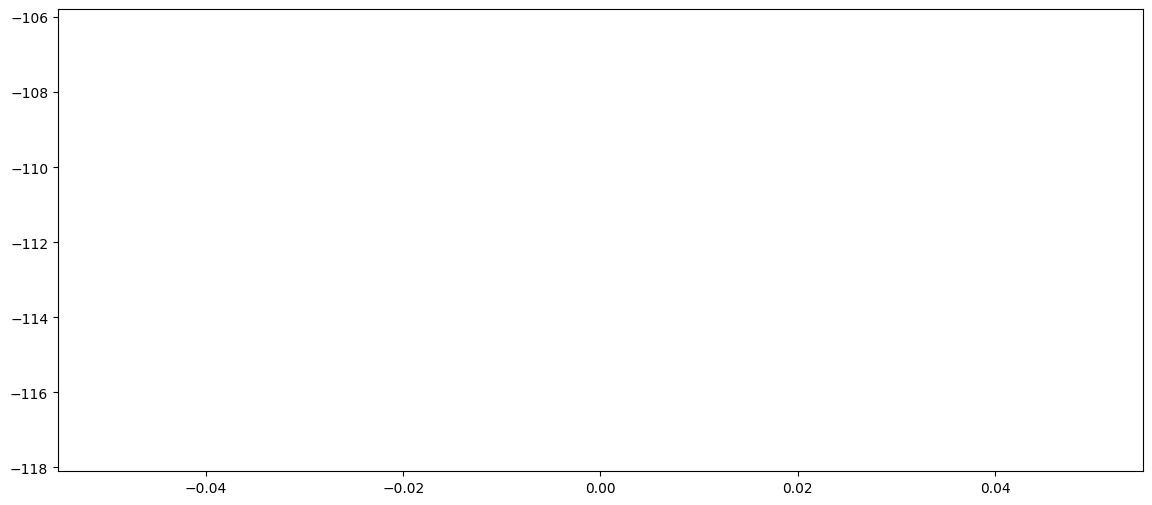

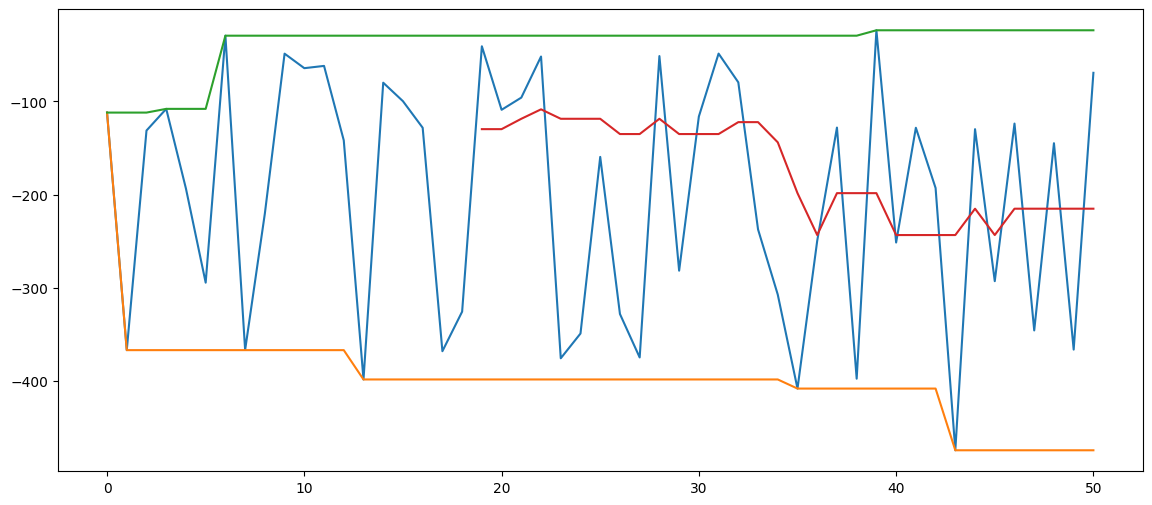

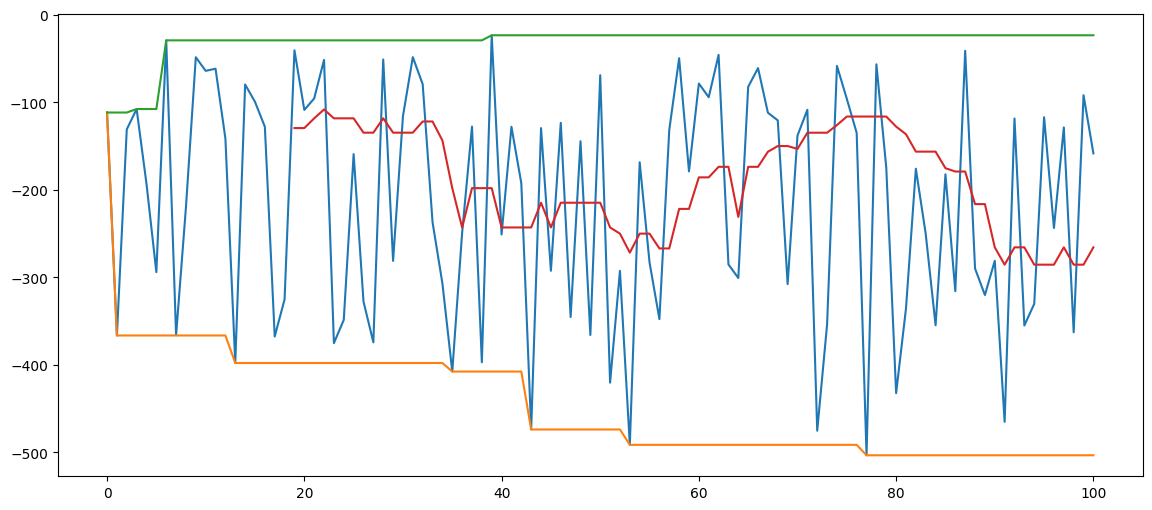

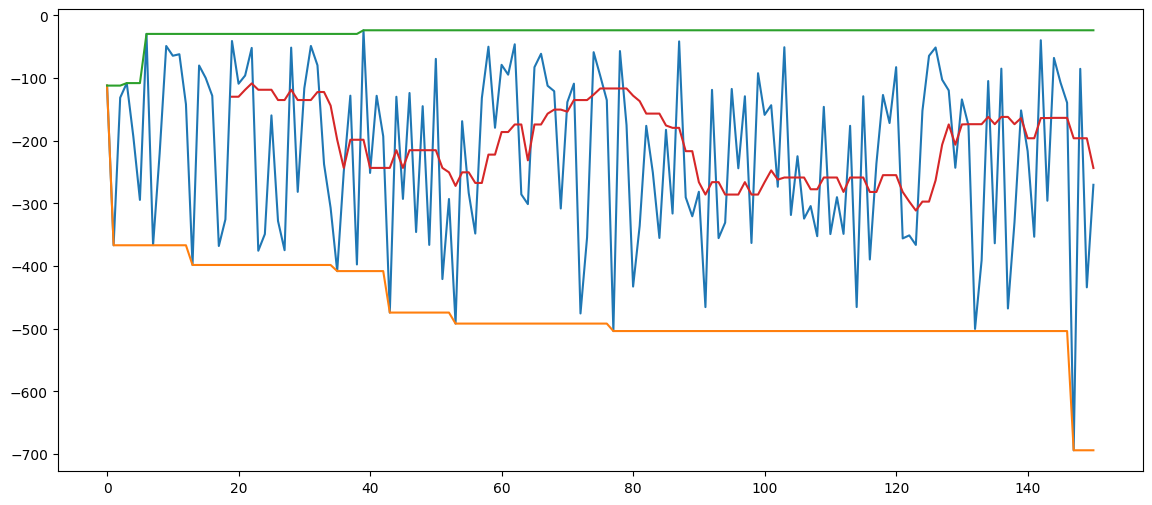

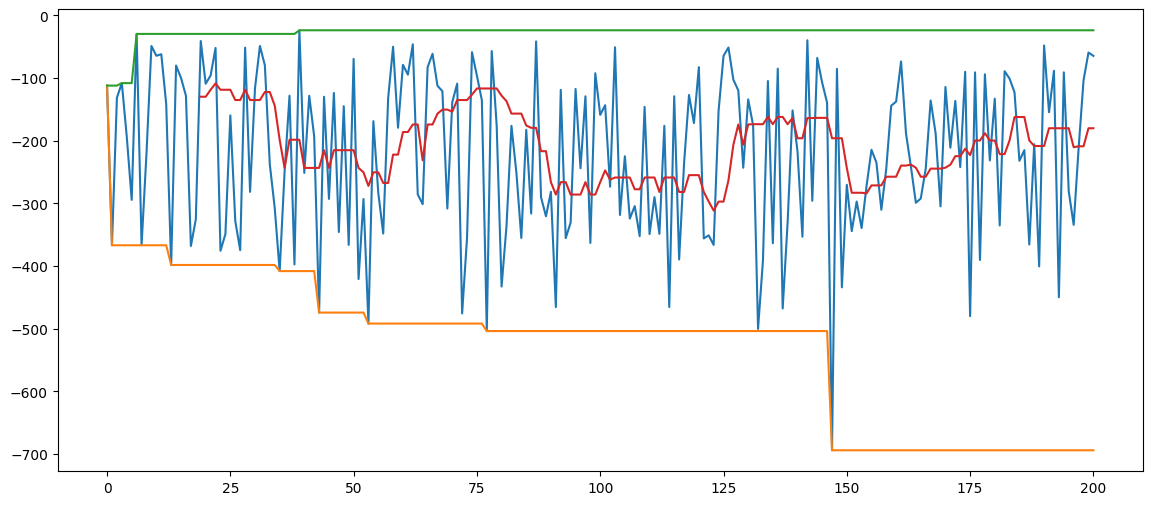

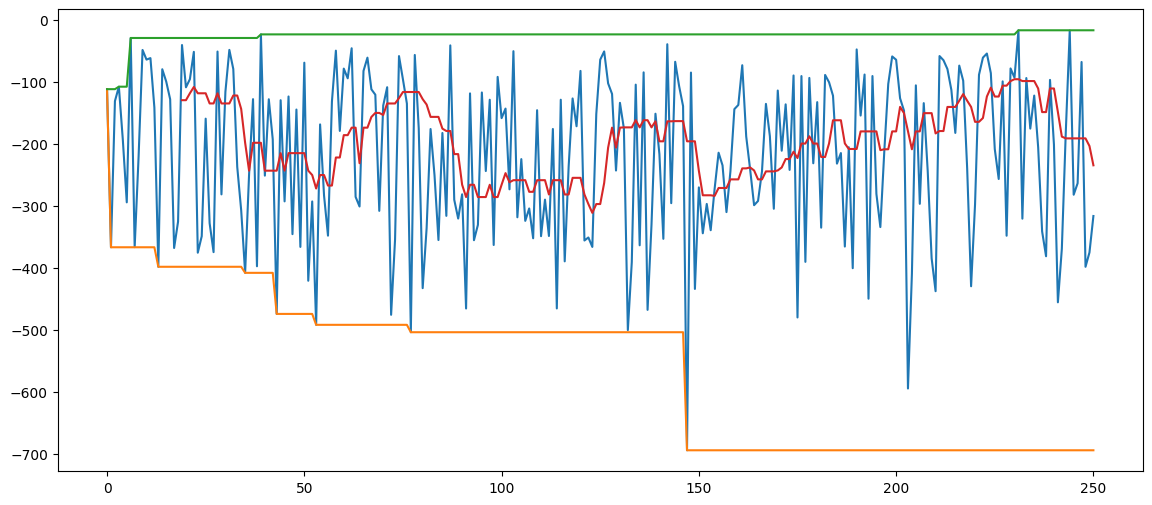

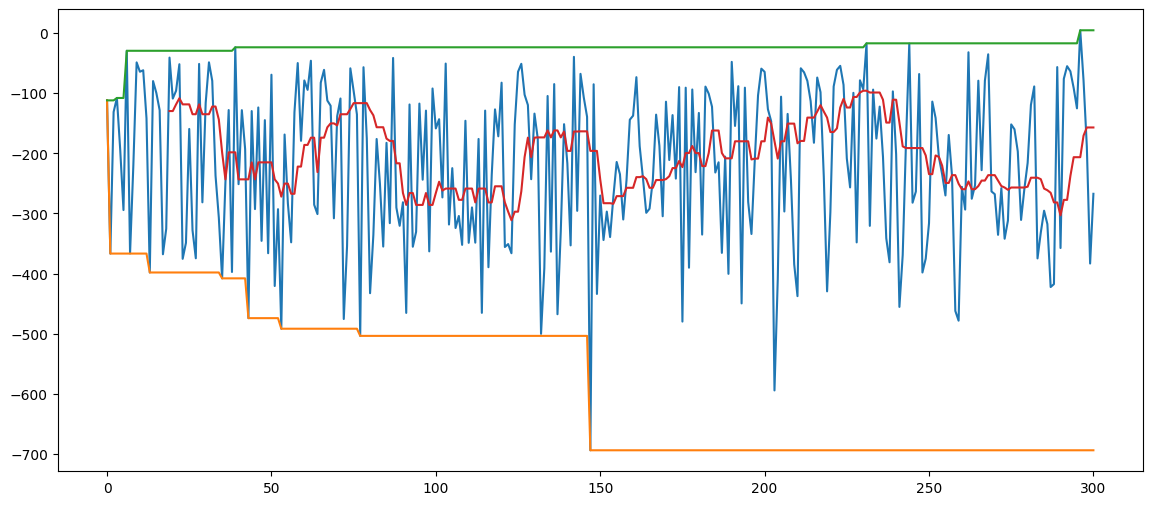

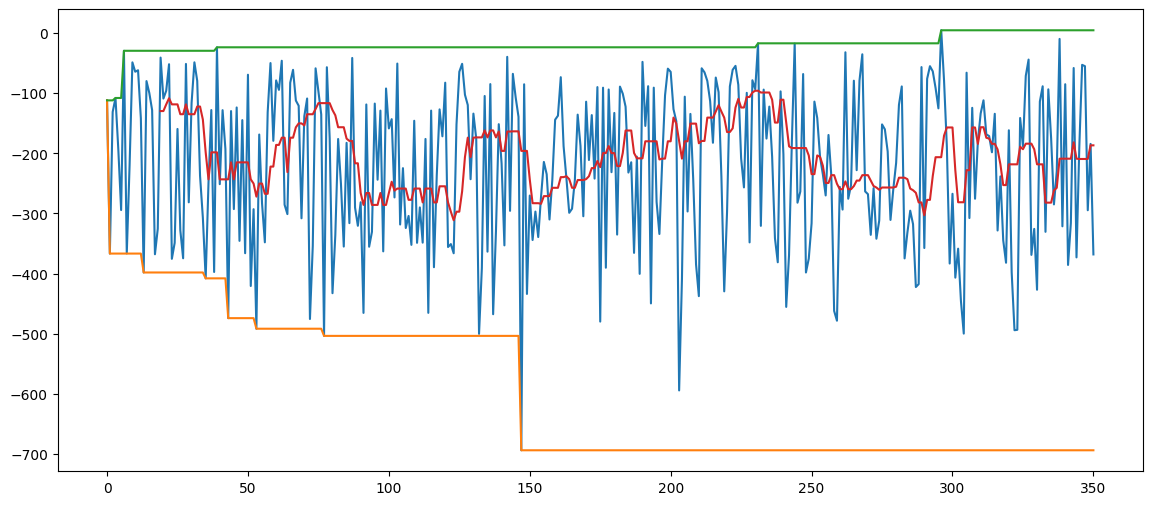

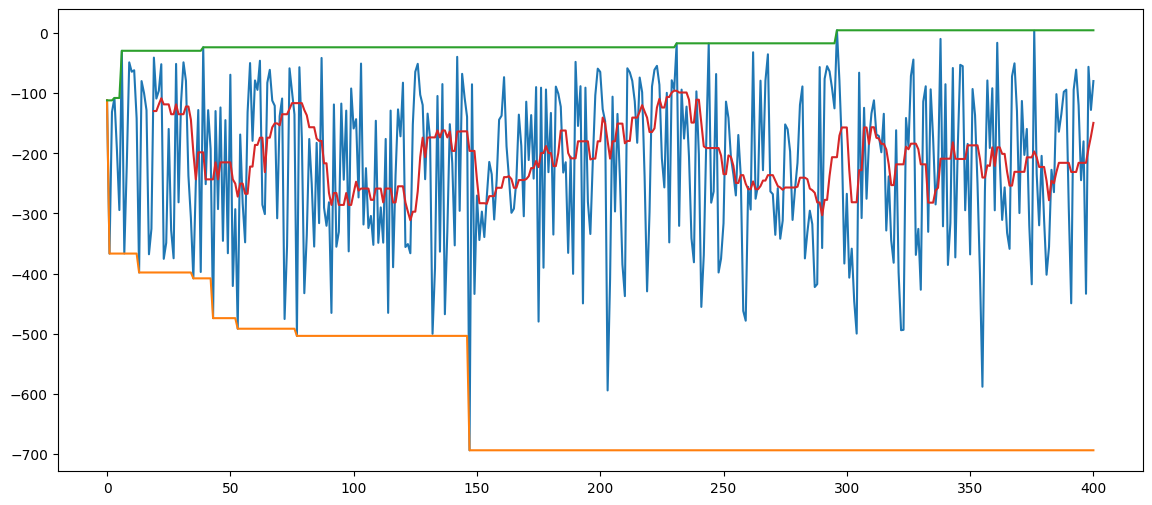

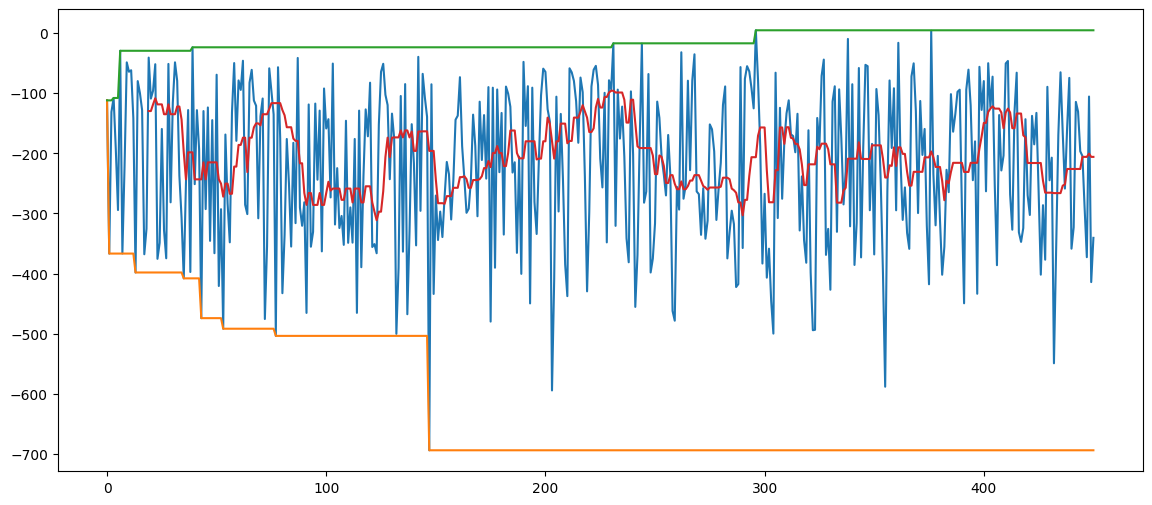

In [6]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("LunarLanderContinuous-v2")


class RandomAgent(Agent):
  def __init__(self, env):
    super().__init__(env)

  def process_transition(self, observation, action, reward, next_observation, done):
    pass

  def get_action(self, observation, learning):
    return self.action_space.sample()


random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 500, plot=True, plot_interval=50)

## Zad 4.1 - Deep Deterministic Policy Gradient (10pkt)

W komórkach poniżej zaimplementuj Deep Deterministic Policy Gradient dla środowiska `LunarLanderContinuous` z eksploracją opartą o dodawanie szumu Gaussowskiego, a jako aproksymatorów użyj prostych sieci neuronowych zaimplementowanych z wykorzystaniem biblioteki PyTroch.

Uwagi:
- Dobra polityka powina mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj by domyślnie Twoja implemnetacja działałą na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architektuę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.

#### Uwaga: nie zmieniaj nazwy klasy `DDPGAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

In [70]:
import torch
from torch import no_grad, hstack, Tensor
from collections import deque, namedtuple
from random import choices
from torch.optim import AdamW
from typing import List
from torch.nn import Sequential, Module, Linear, ReLU, Tanh, MSELoss
from copy import deepcopy


class dotdict(dict):
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__


Experience = namedtuple("Experience", field_names=[
  "state",
  "action",
  "reward",
  "next_state",
  "done"
])


class DDPGModel(Module):
  def __init__(self, *, input_size: int, hidden_sizes: List[int] = None, output_size: int, is_actor: bool):
    super().__init__()

    layers = [
      input_size,
      *(hidden_sizes or [32, 64, 128]),
      output_size
    ]

    modules = []
    for i in range(len(layers) - 1):
      modules.append(Linear(layers[i], layers[i + 1]))
      if i == len(layers) - 2: continue
      modules.append(ReLU())

    if is_actor: modules.append(Tanh())

    self.model = Sequential(*modules)

  def forward(self, x):
    return self.model(x)

  def sync_with(self, other: 'DDPGModel', transfer_rate: float = 1):
    for original, new in zip(self.parameters(), other.parameters()):
      original.data.copy_(transfer_rate * new.data + (1.0 - transfer_rate) * original.data)


class MemoryModule(object):
  def __init__(self, capacity: int = None) -> None:
    self.contents = deque(maxlen=capacity)

  def __len__(self) -> int:
    return len(self.contents)

  def append(self, experience: Experience) -> None:
    self.contents.append(experience)

  def sample(self, count: int) -> List[Experience]:
    return choices(self.contents, k=count)


class DDPGAgent(Agent):
  def __init__(
      self,
      env,
      discount_factor: float = 0.99,
      epsilon: float = 0.8,
      epsilon_min: float = 0.1,
      epsilon_decay: float = 0.99,
      transfer_rate: float = 0.01,
      actor_learning_rate: float = 0.0001,
      actor_layers: float = None,
      critic_layers: float = None,
      critic_learning_rate: float = 0.01,
      batch_size: float = 128,
      buffer_size: int = 1_000_000
  ):
    super().__init__(env)
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.action_bounds = (env.action_space.low, env.action_space.high)
    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay = epsilon_decay
    self.discount_factor = discount_factor
    self.transfer_rate = transfer_rate

    self.batch_size = batch_size
    self.memory = MemoryModule(capacity=buffer_size)

    self.input_size = env.observation_space.shape[0]
    self.output_size = env.action_space.shape[0]
    self.actor = DDPGModel(
      input_size=self.input_size,
      hidden_sizes=actor_layers or [128, 128],
      output_size=self.output_size,
      is_actor=True
    ).to(self.device)
    self.actor_target = deepcopy(self.actor).to(self.device)
    self.actor_optim = AdamW(self.actor.parameters(), lr=actor_learning_rate)

    self.critic = DDPGModel(
      input_size=self.input_size + self.output_size,
      hidden_sizes=critic_layers or [128, 128],
      output_size=1,
      is_actor=False
    ).to(self.device)
    self.critic_target = deepcopy(self.critic).to(self.device)
    self.critic_optim = AdamW(self.critic.parameters(), lr=critic_learning_rate)
    self.loss = MSELoss()

  def transfer_knowledge(self):
    self.actor_target.sync_with(self.actor, self.transfer_rate)
    self.critic_target.sync_with(self.critic, self.transfer_rate)

  def update_epsilon(self):
    self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

  def process_transition(self, observation, action, reward, next_observation, done):
    if isinstance(observation, tuple): observation = observation[0]
    self.memory.append(Experience(action, reward, observation, next_observation, done))

    if not self.should_train(): return
    self.train(self.memory.sample(self.batch_size))

    if done: self.update_epsilon()
    self.transfer_knowledge()

  def should_train(self):
    return len(self.memory) >= self.batch_size

  def train(self, experiences: Experience):
    actions, rewards, states, states_next, dones = map(lambda x: Tensor(x).to(self.device), zip(*experiences))
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    with no_grad():
      actions_next = self.actor_target(states_next)
      qualities_next = self.critic_target(hstack((states_next, actions_next)))

    expected = rewards + self.discount_factor * qualities_next * (1 - dones)
    predicted = self.critic(hstack((states, actions)))

    loss = self.loss(expected, predicted)
    self.critic_optim.zero_grad()
    loss.backward()
    self.critic_optim.step()

    loss = -self.critic(hstack((states, self.actor(states)))).mean()
    self.actor_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()

    if done: self.update_epsilon()
    self.transfer_knowledge()

  def get_action(self, observation, learning):
    if isinstance(observation, tuple): observation = observation[0]

    with no_grad():
      state = torch.from_numpy(observation).unsqueeze(dim=0).to(self.device)
      action = (
          self.actor(state)[0].cpu().numpy()
          + learning * np.random.normal(scale=self.epsilon, size=self.output_size)
      )
    return np.clip(action, *self.action_bounds)

KeyboardInterrupt: 

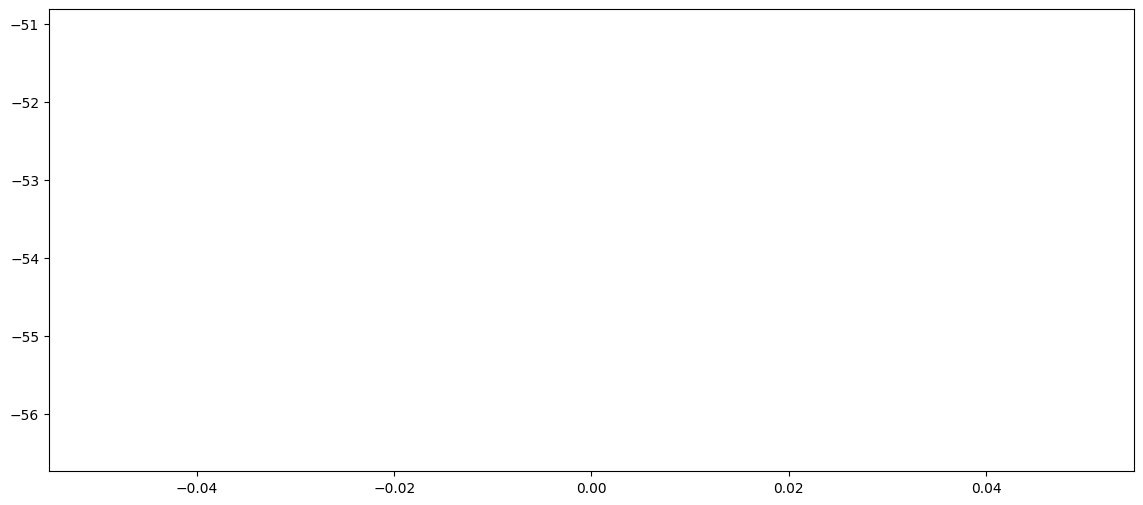

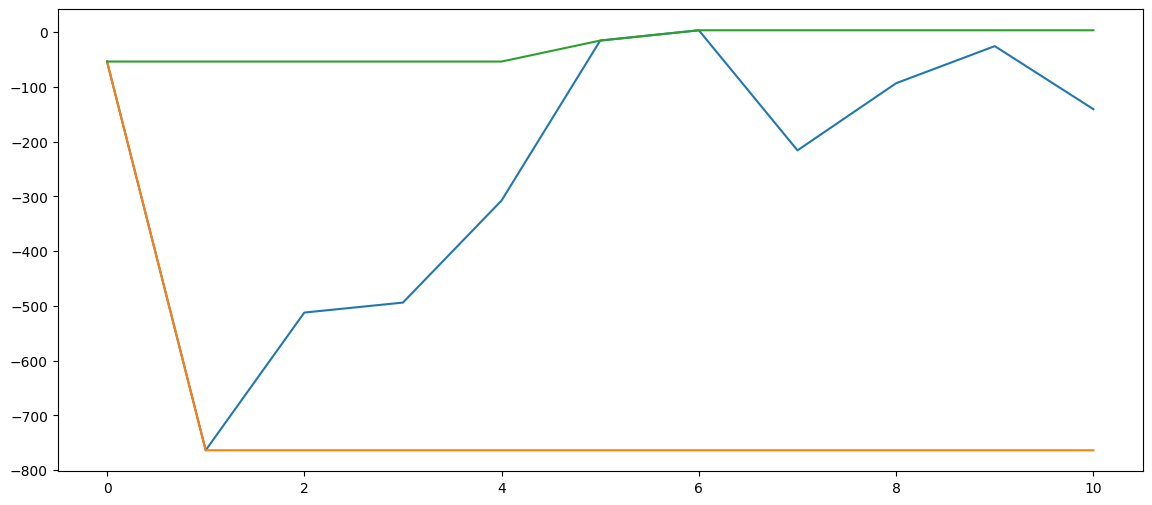

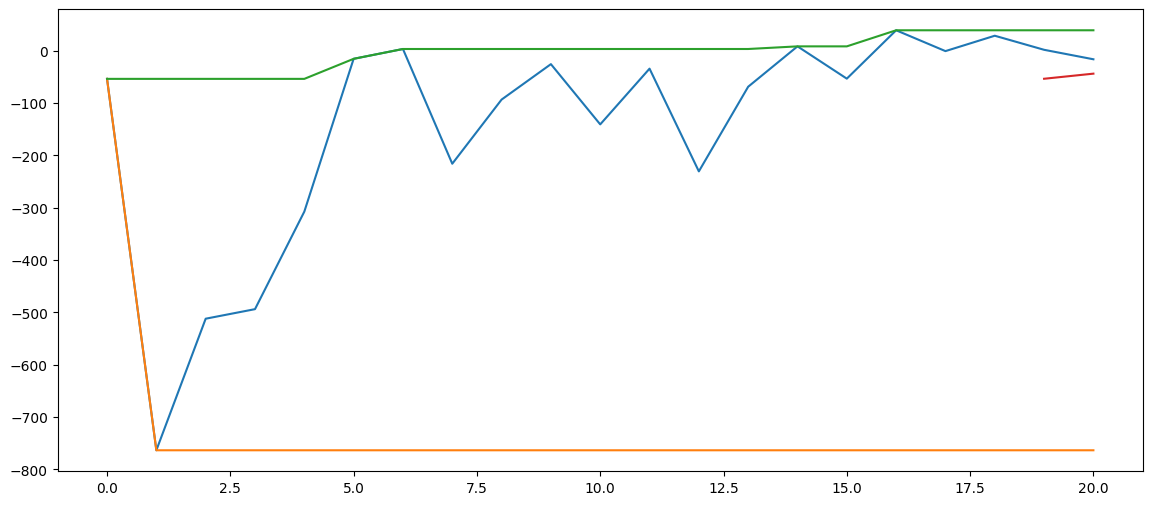

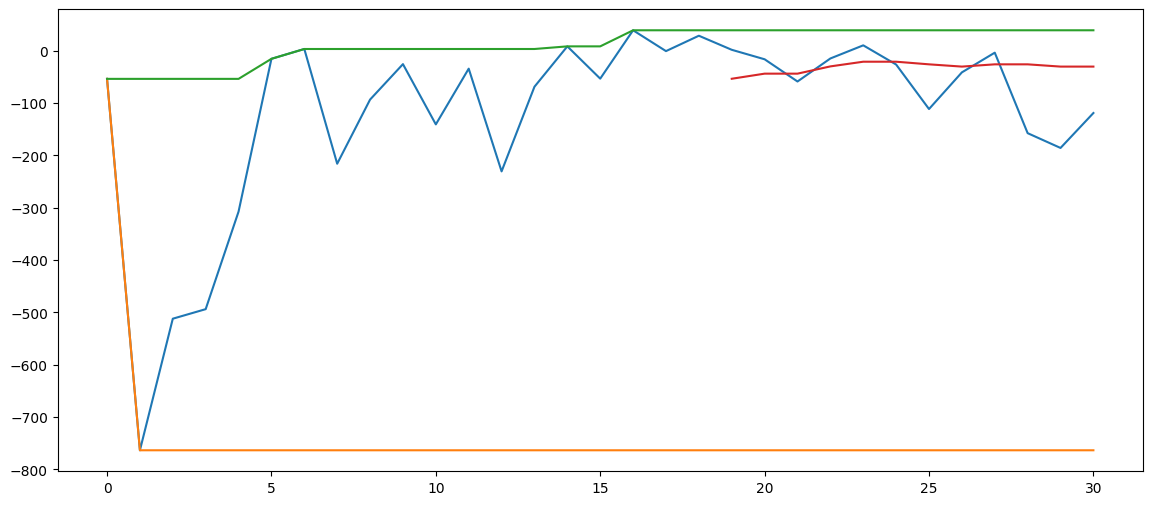

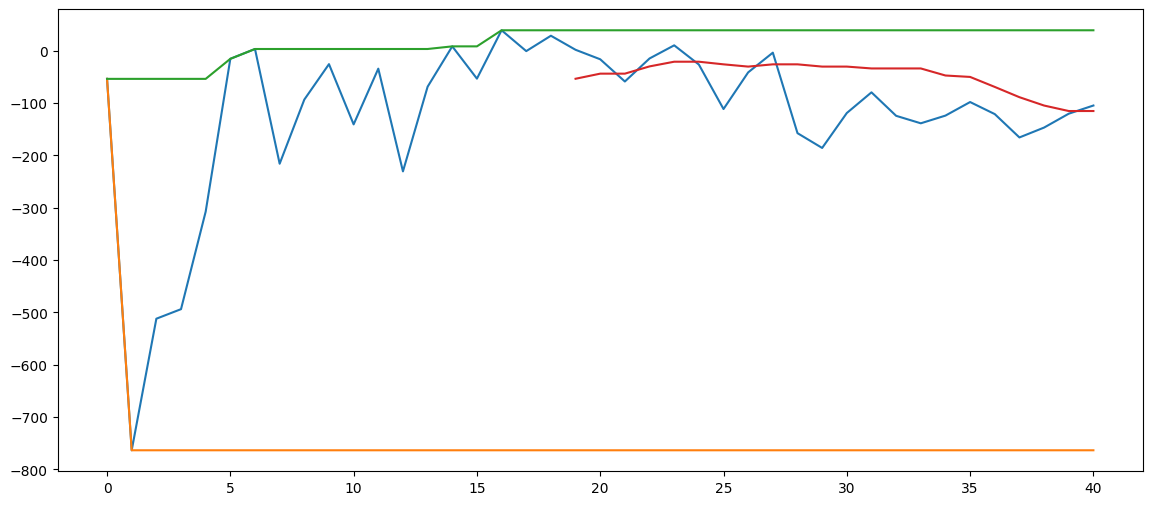

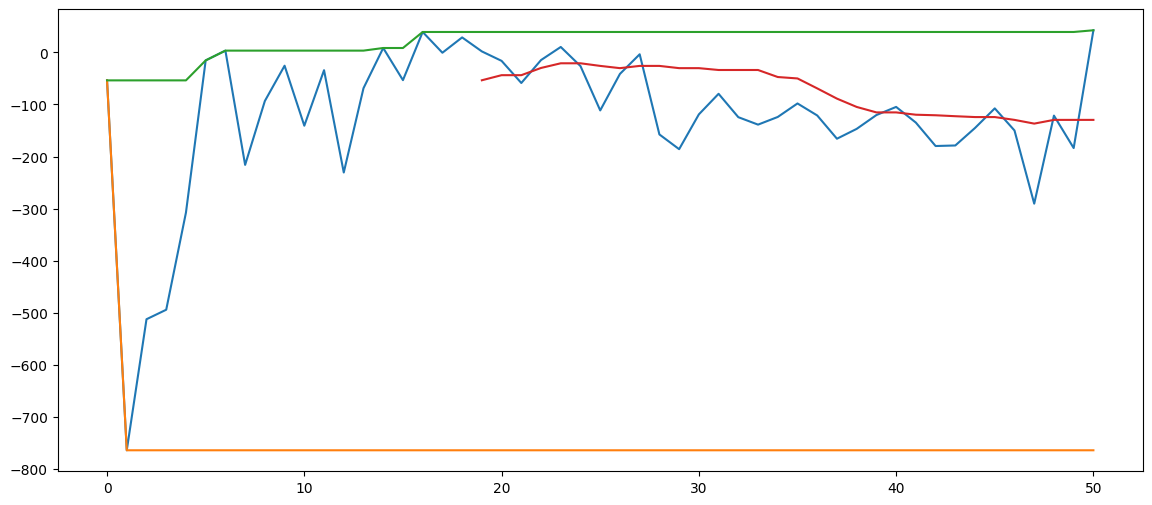

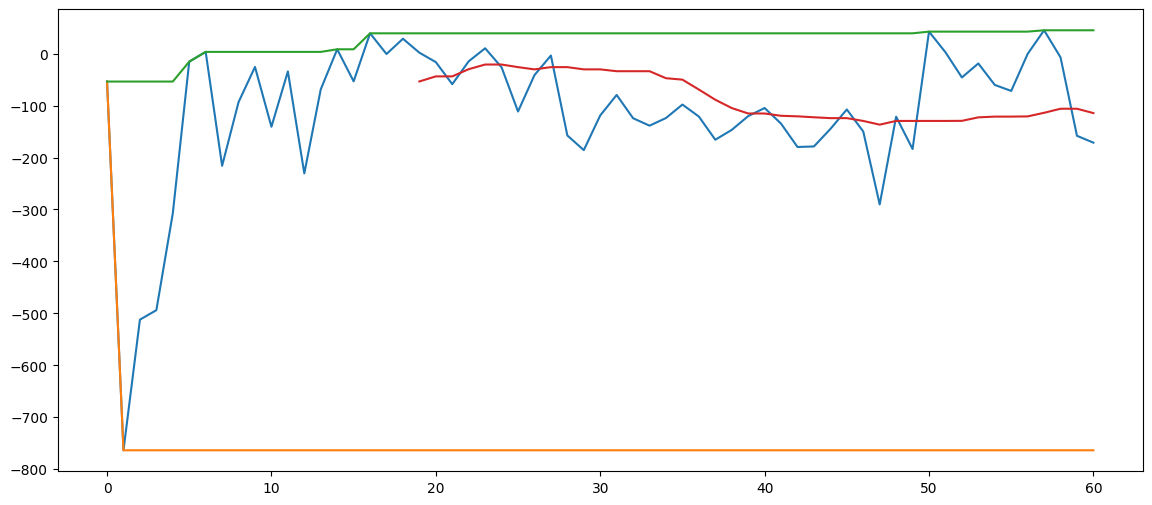

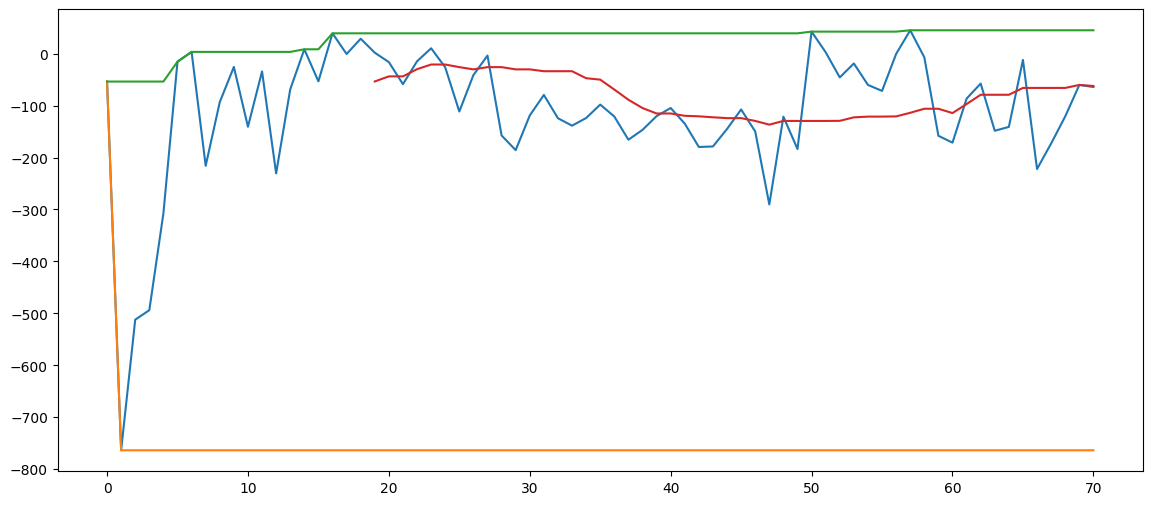

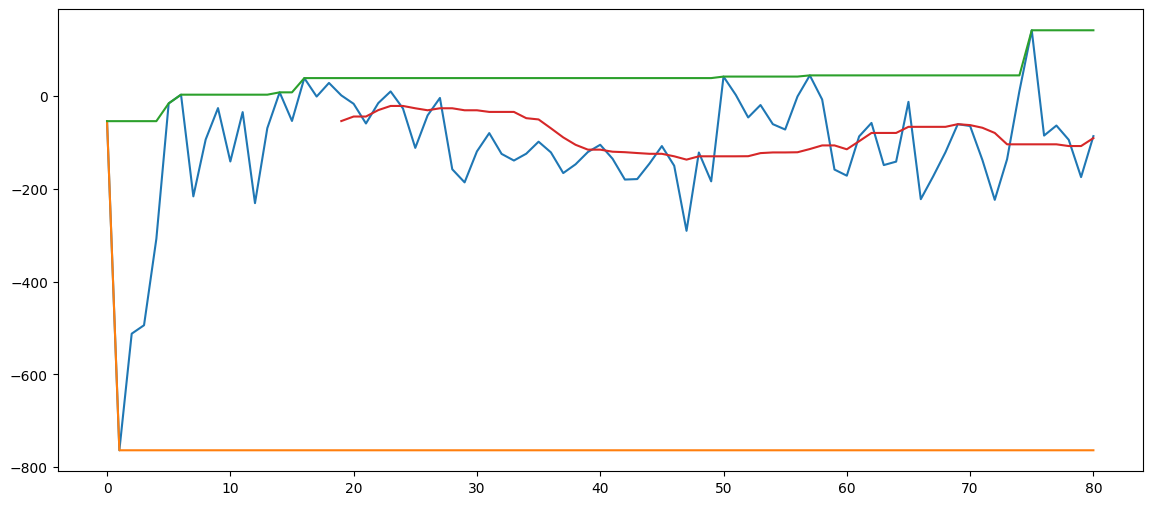

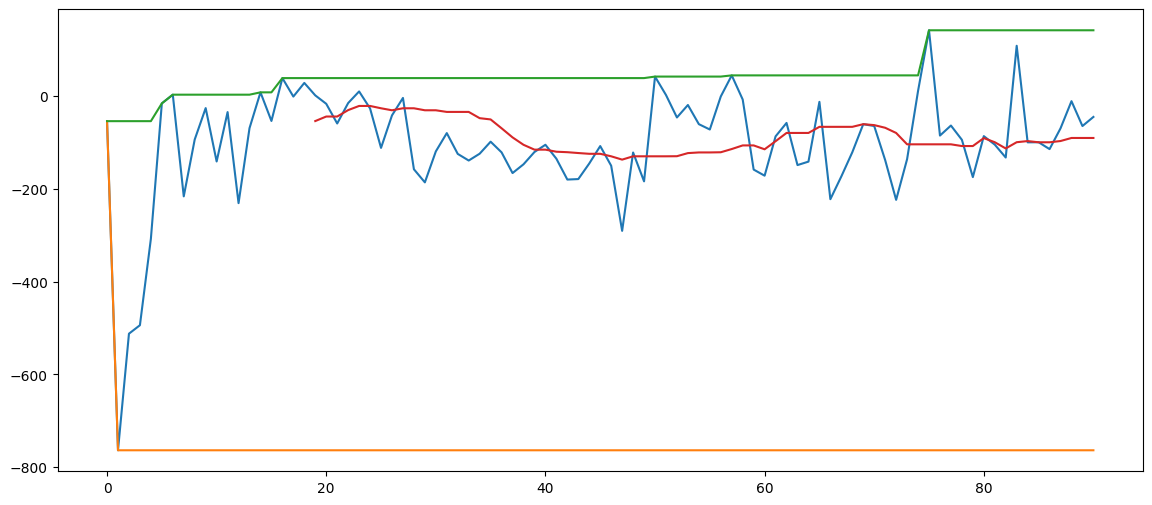

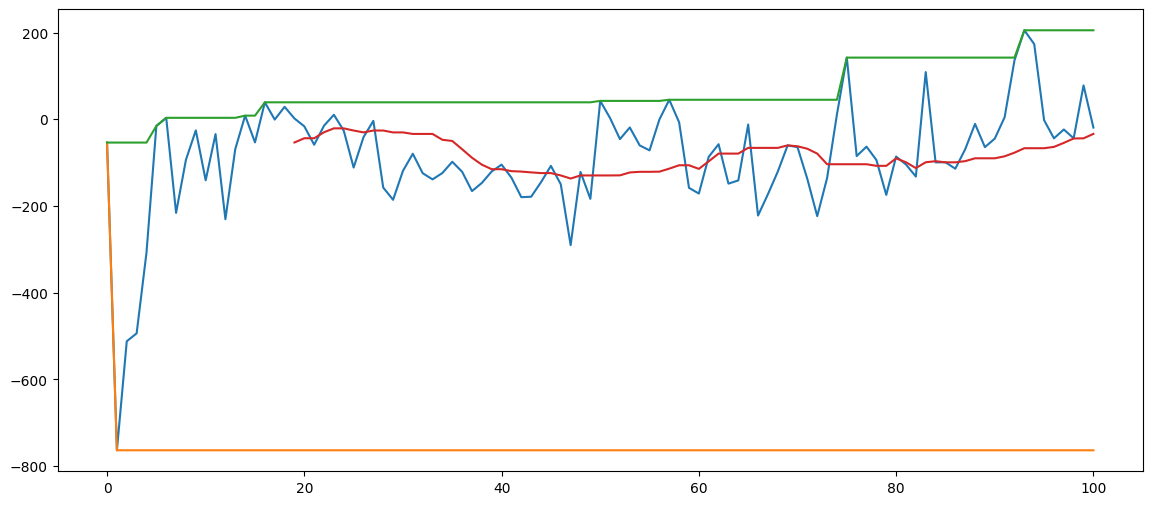

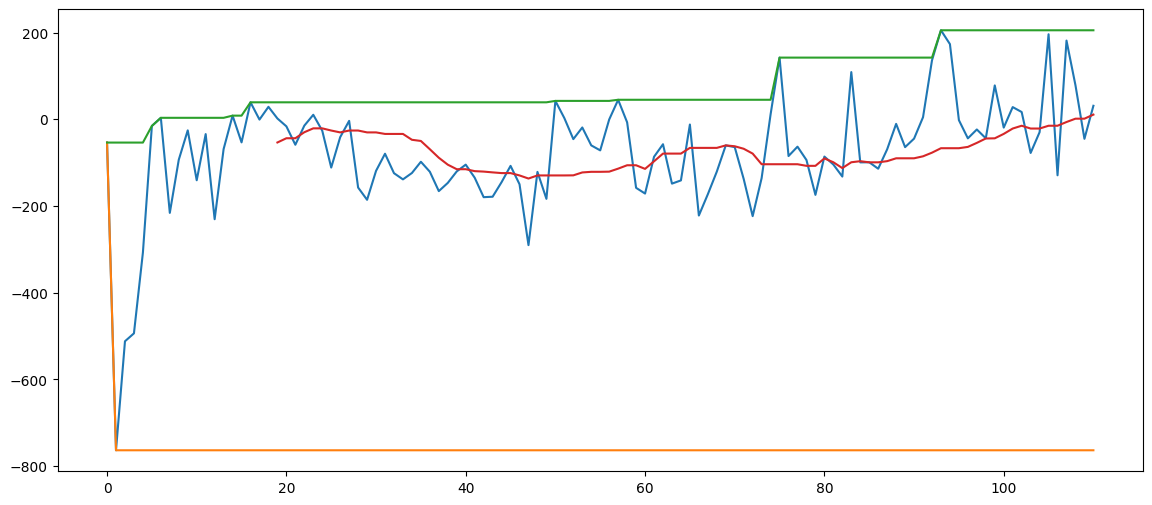

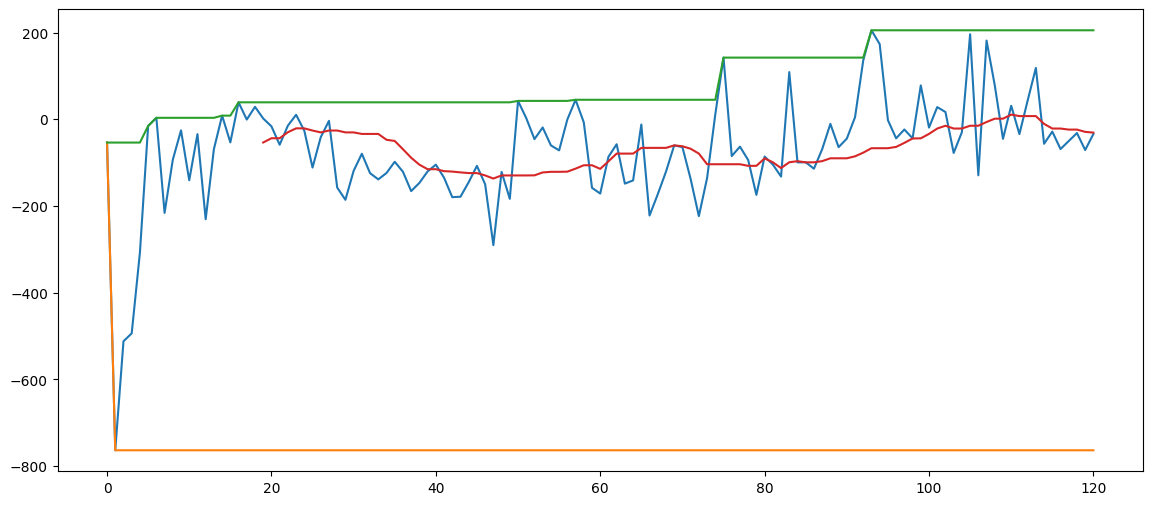

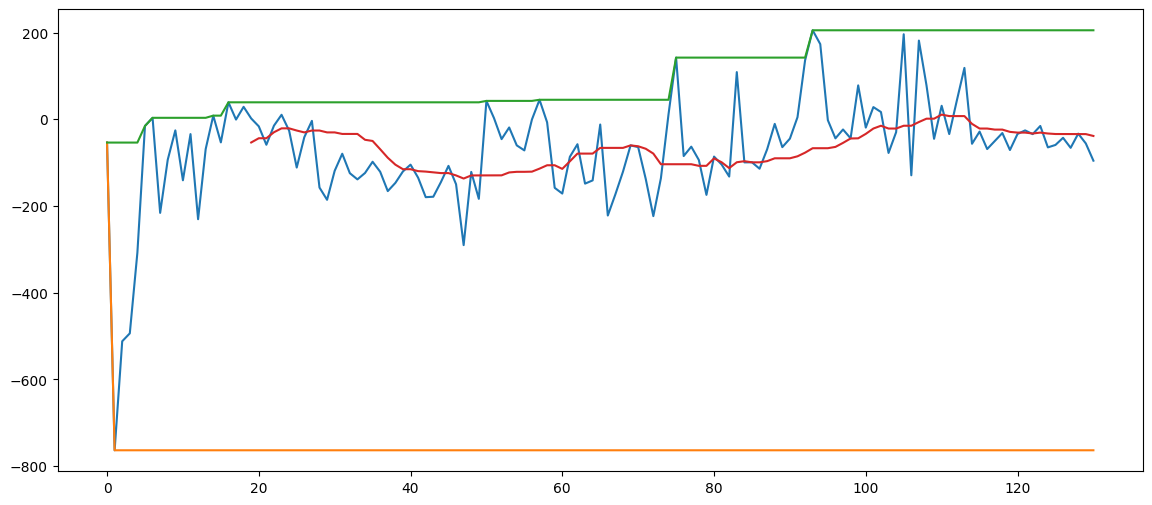

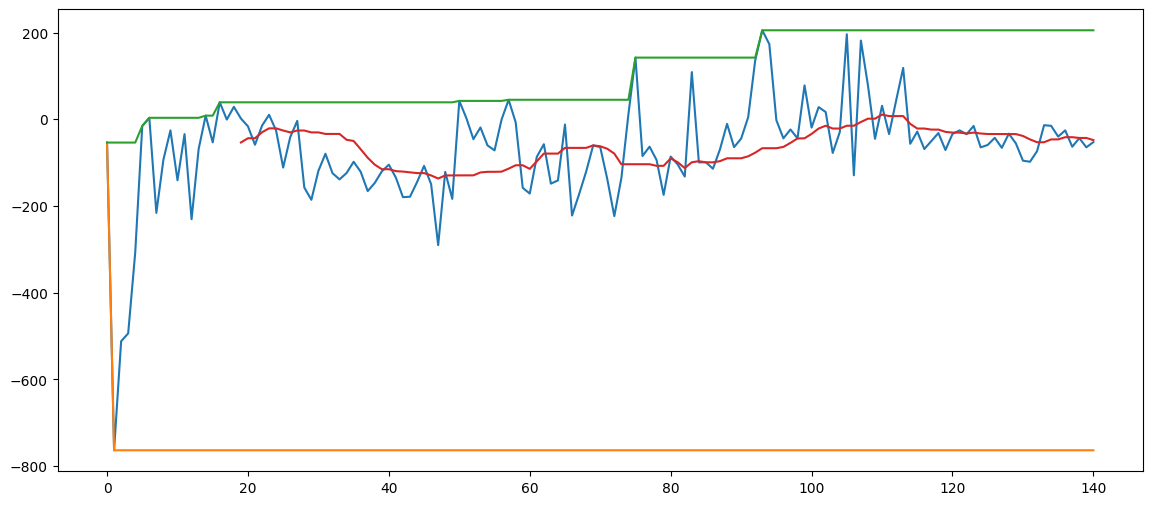

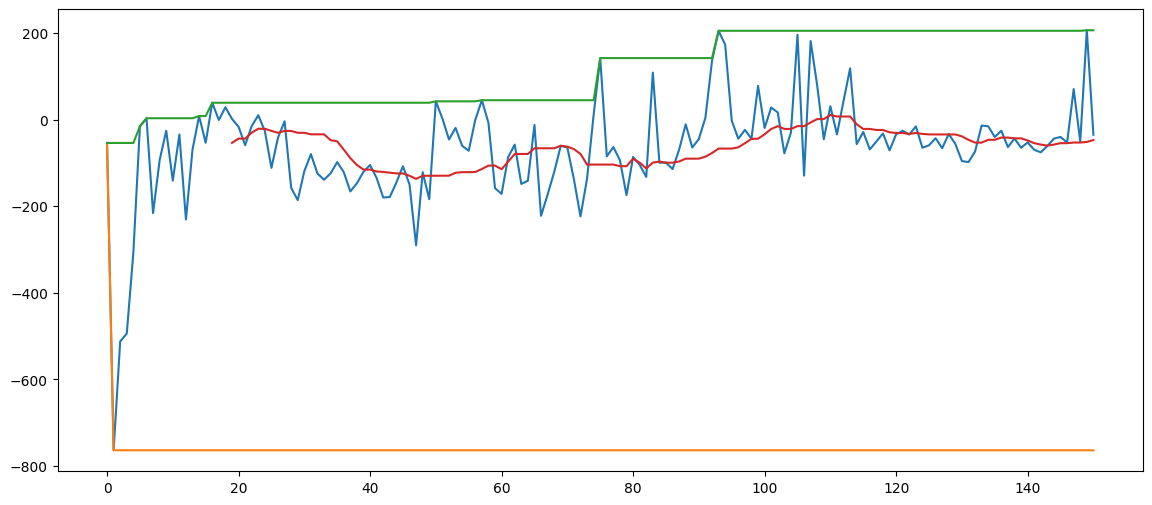

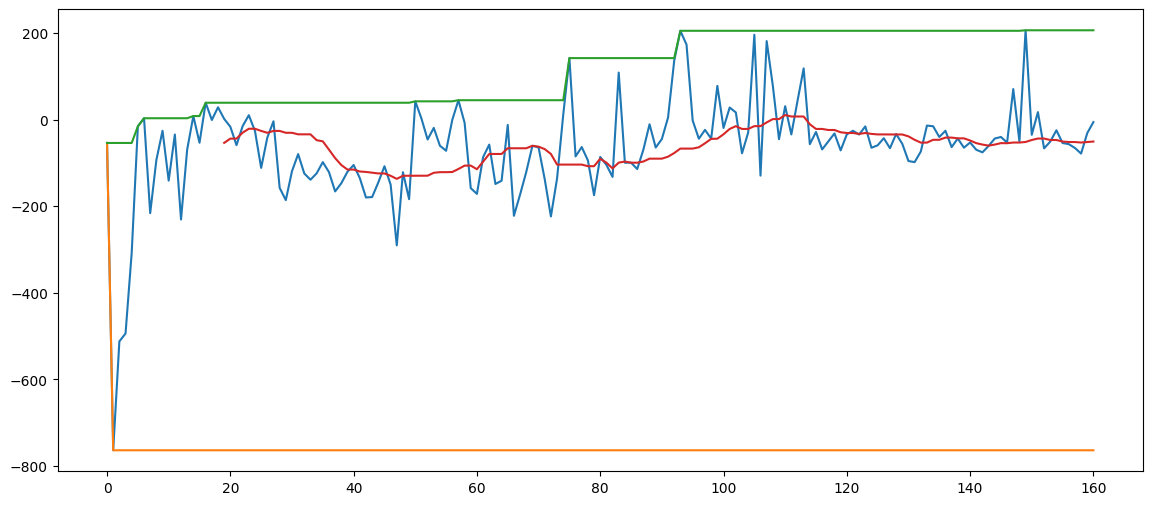

In [71]:
# Uczenie/testowania agenta — Trwa 1000 lat, Fuj!, im dalej tym gorzej, przez chwilę był powyżej 0, a raz nawet 200 zaliczył, mi to wystarczy, żeby wiedzieć, że coś tam się uczy :D
env = gym.make("LunarLanderContinuous-v2")
player = DDPGAgent(env)
rewards = run_agent_in_env(env, player, 251, learning=True, plot=True, plot_interval=10)

## Wprowadzenie do Zadania 4.2

Zadanie będzie polegało na implementacji algorytmu Monte Carlo Tree Search (MCTS) dla środowiska `Connect Four` z biblioteki DeepMind OpenSpiel (https://github.com/deepmind/open_spiel).

In [9]:
# Zainstaluj bibliotekę DeepMind OpenSpiel (tylko Linux i MacOS)
!pip install open_spiel

~/.config/fish/config.fish (line 4): Unsupported use of '='. In fish, please use 'set bashrc $HOME/.bashrc'.
bashrc=$HOME/.bashrc
^~~~~~~~~~~~~~~~~~~^
from sourcing file ~/.config/fish/config.fish
	called during startup
source: Error while reading file '/home/teba_dzdancewicz/.config/fish/config.fish'
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.11 -m pip install --upgrade pip' command.


### Środowisko `Connect Four`

Poniższy kod demonstruje działanie środowiska `Connect Four` (https://en.wikipedia.org/wiki/Connect_Four), gry dla dwóch graczy, deterministycznej z pełną informacją.

In [72]:
# Zobacz jak działają środowisko na przykładzie jednej gry
import random
import pyspiel
import numpy as np

game = pyspiel.load_game("connect_four")
state = game.new_initial_state()

while not state.is_terminal():
  print('Tura gracza:', state.current_player())
  print('Ruch:', state.move_number())
  print('Stan:'),
  print(state.observation_string())
  print('Dopuszczalne akcje:', state.legal_actions())
  a = np.random.choice(state.legal_actions())  # Wybieramy losową z dopuszczalnych akcji
  print('Wybrana akcja:', a)
  state.apply_action(a)  # Stosujemy akcję
  print('-------')
print('Koniec gry, wyniki:', state.player_reward(0), ':', state.player_reward(1))  # albo state.rewards()

Tura gracza: 0
Ruch: 0
Stan:
.......
.......
.......
.......
.......
.......

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 4
-------
Tura gracza: 1
Ruch: 1
Stan:
.......
.......
.......
.......
.......
....x..

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 5
-------
Tura gracza: 0
Ruch: 2
Stan:
.......
.......
.......
.......
.......
....xo.

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 5
-------
Tura gracza: 1
Ruch: 3
Stan:
.......
.......
.......
.......
.....x.
....xo.

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 0
-------
Tura gracza: 0
Ruch: 4
Stan:
.......
.......
.......
.......
.....x.
o...xo.

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 5
-------
Tura gracza: 1
Ruch: 5
Stan:
.......
.......
.......
.....x.
.....x.
o...xo.

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana akcja: 6
-------
Tura gracza: 0
Ruch: 6
Stan:
.......
.......
.......
.....x.
.....x.
o...xoo

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Wybrana ak

In [73]:
# Obiekt State zawiera kilka innych przydatnych metod i pól
[a for a in dir(state) if '__' not in a]

['action_to_string',
 'apply_action',
 'apply_action_with_legality_check',
 'apply_actions',
 'apply_actions_with_legality_checks',
 'chance_outcomes',
 'child',
 'clone',
 'current_player',
 'distribution_support',
 'full_history',
 'get_game',
 'get_type',
 'history',
 'history_str',
 'information_state_string',
 'information_state_tensor',
 'is_chance_node',
 'is_initial_state',
 'is_mean_field_node',
 'is_player_node',
 'is_simultaneous_node',
 'is_terminal',
 'legal_actions',
 'legal_actions_mask',
 'mean_field_population',
 'move_number',
 'num_distinct_actions',
 'num_players',
 'observation_string',
 'observation_tensor',
 'player_return',
 'player_reward',
 'resample_from_infostate',
 'returns',
 'rewards',
 'serialize',
 'string_to_action',
 'to_string',
 'undo_action',
 'update_distribution']

In [75]:
# Np. historię akcji:
[(a.player, a.action) for a in state.full_history()]

[(0, 4),
 (1, 5),
 (0, 5),
 (1, 0),
 (0, 5),
 (1, 6),
 (0, 4),
 (1, 0),
 (0, 0),
 (1, 4),
 (0, 0),
 (1, 2),
 (0, 2),
 (1, 2),
 (0, 2),
 (1, 2),
 (0, 2),
 (1, 6),
 (0, 1),
 (1, 1),
 (0, 5),
 (1, 4),
 (0, 3),
 (1, 6),
 (0, 1)]

In [76]:
# Albo klonowanie stanu
state.clone()

..x....
..o....
x.x.ox.
xxo.oxo
oox.xxo
oxoxxoo

In [77]:
# Rozegraj grę z gotową implementacją MCTS,
# Ty zawsze zaczynasz (masz przewagę, rozpoczynający optymalny gracz zawsze powinien wygrać)
from math import sqrt
from open_spiel.python.algorithms import mcts

game = pyspiel.load_game("connect_four")
state = game.new_initial_state()

# Drugi argument MCTSBot to paramter c w UCB, trzeci argument to liczba symulacji,
# im mniej symulacji tym większa szansa, że bot wykona słaby ruch,
# sprawdz czy jesteś w stanie wygrać z botem o 10, 100, 1000 symulacjach na ruch
bot = mcts.MCTSBot(game, sqrt(2), 1000, mcts.RandomRolloutEvaluator())

while not state.is_terminal():
  if (state.current_player() == 1):
    a = bot.step(state)
  else:
    print('Tura gracza:', state.current_player())
    print('Ruch:', state.move_number())
    print('Stan:')
    print(state.observation_string())
    print('Dopuszczalne akcje:', state.legal_actions())
    a = int(input())
  state.apply_action(a)
print('Koniec gry, wyniki:', state.player_reward(0), ':', state.player_reward(1))  # albo state.rewards()

Tura gracza: 0
Ruch: 0
Stan:
.......
.......
.......
.......
.......
.......

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Tura gracza: 0
Ruch: 2
Stan:
.......
.......
.......
.......
.......
.x.o...

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]
Tura gracza: 0
Ruch: 4
Stan:
.......
.......
.......
.......
..o....
.xxo...

Dopuszczalne akcje: [0, 1, 2, 3, 4, 5, 6]


ValueError: invalid literal for int() with base 10: ''

### Interface agenta

Implementacja zadania będzie się opierać o klasę `OpenSpielAgent` przedstawioną poniżej. Powinna ona implementować jedną metodę `step`, która będzie na podstawie otrzymanego stanu zwracać akcję.

Poniżej znajdziesz też funkcję `play_games`, która korzysta z opisanego wyżej obiektu agenta w celu jego ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu sumy nagród z minionych epizodów (gier), który uaktualnia się co ich zadaną liczbę.

In [78]:
class OpenSpielAgent:
  def __init__(self, game):
    self.game = game

  def step(self, state):
    raise NotImplementedError()

In [80]:
import matplotlib.pylab as plt
from IPython import display
% matplotlib inline
from tqdm.notebook import tqdm


def plot_rewards(rewards):
  display.clear_output(wait=True)
  plt.figure(figsize=(14, 6))
  for r in rewards:
    plt.plot(r)
  display.display(plt.gcf())


def play_game(game, agents, episodes, plot=False, plot_interval=1000):
  assert len(agents) == game.num_players()
  rewards_history = [[0] for _ in agents]
  for episode in tqdm(range(episodes)):
    state = game.new_initial_state()
    while not state.is_terminal():
      p = (state.current_player() + episode) % game.num_players()
      a = agents[p].step(state.clone())
      try:
        state.apply_action(a)
      except:
        print("Agent selected inlegal action, using random action instead")
        state.apply_action(np.random.choice(state.legal_actions()))

    for i in range(game.num_players()):
      p = (i + episode) % game.num_players()
      rewards_history[i].append(rewards_history[i][-1] + state.player_reward(p))

    # Wyświetl na wykresie sumę nagród z minionych epizodów
    if plot and episode % plot_interval == 0:
      plot_rewards(rewards_history)
  return rewards_history

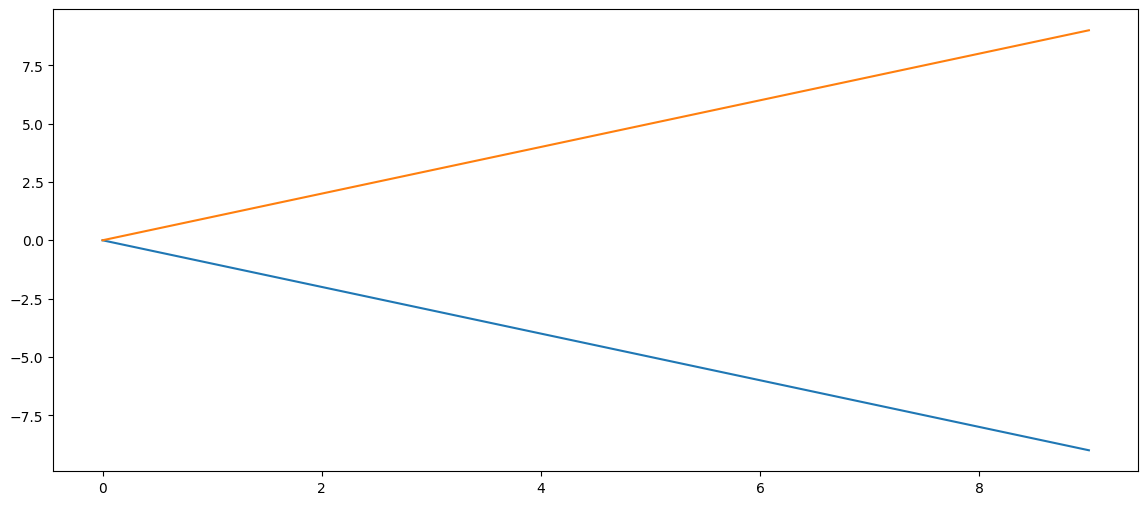

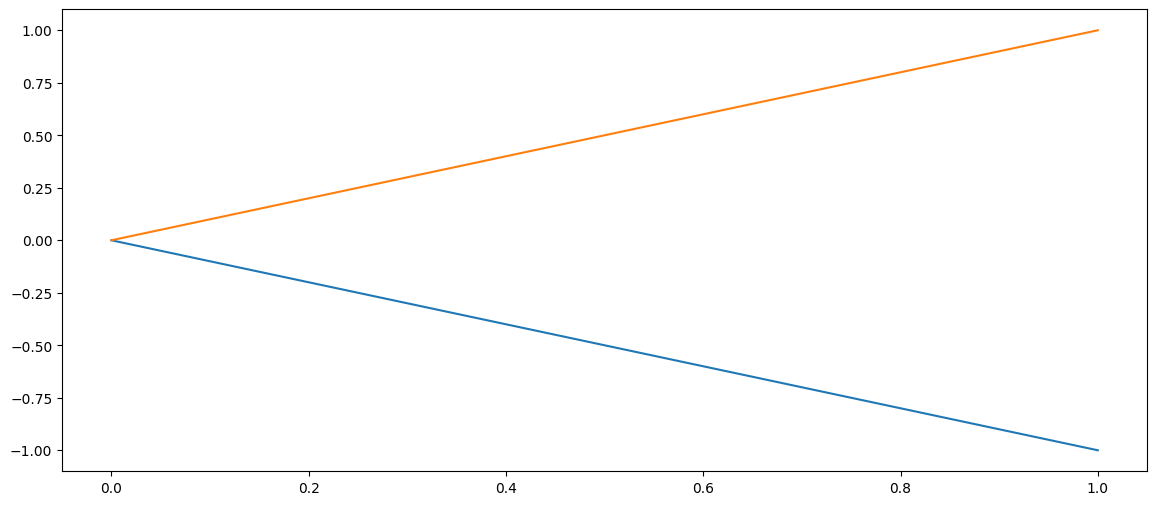

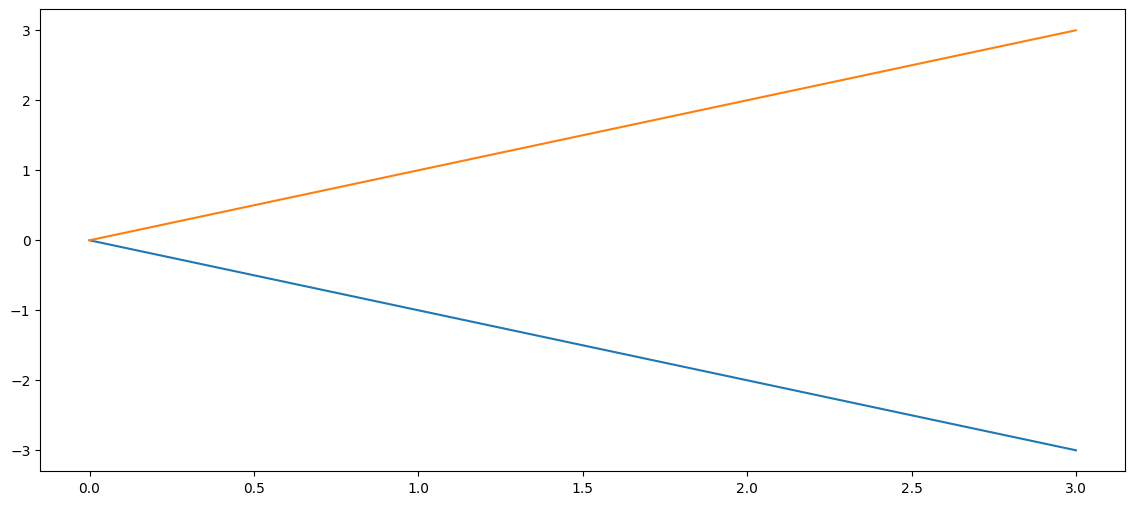

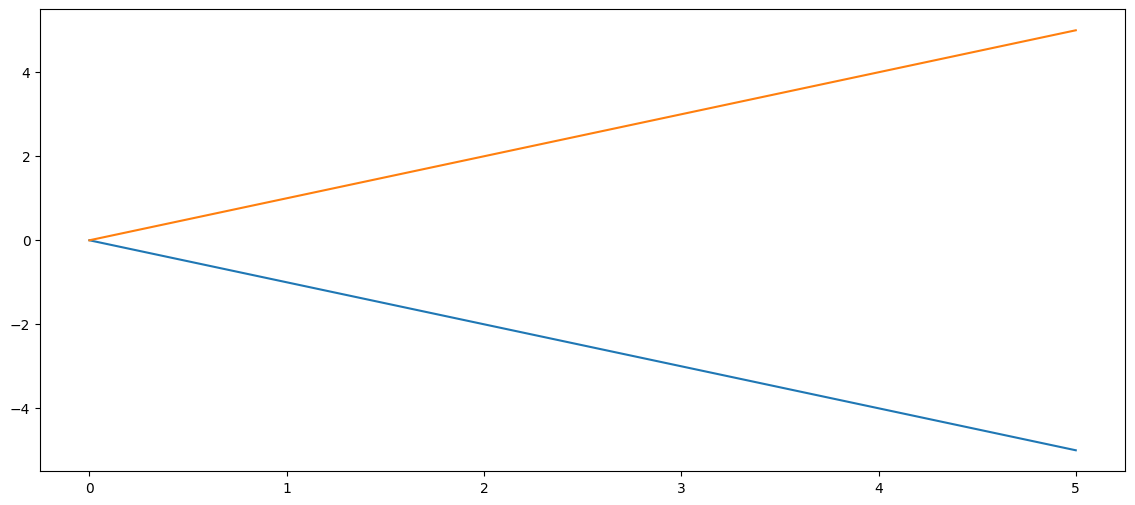

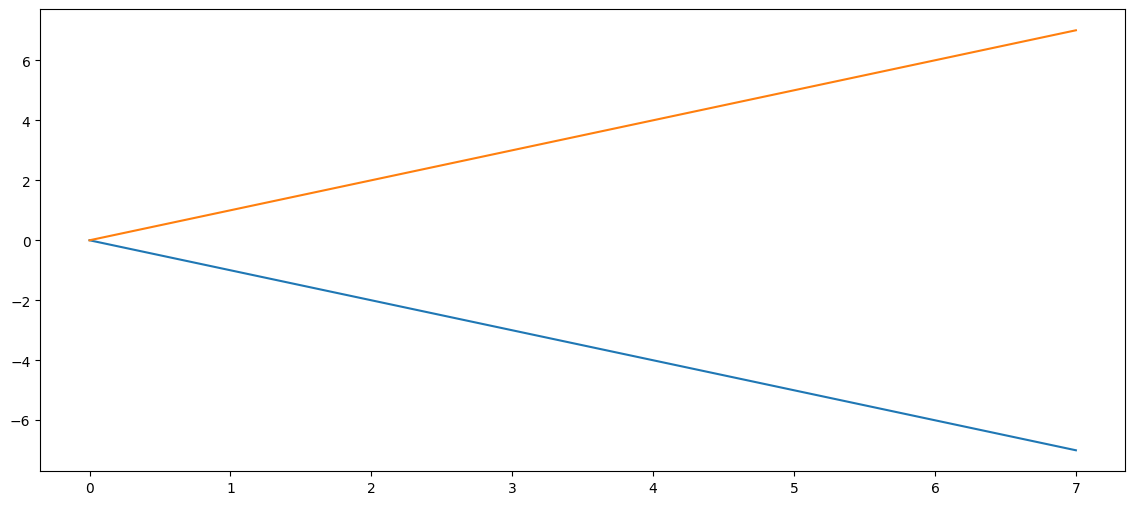

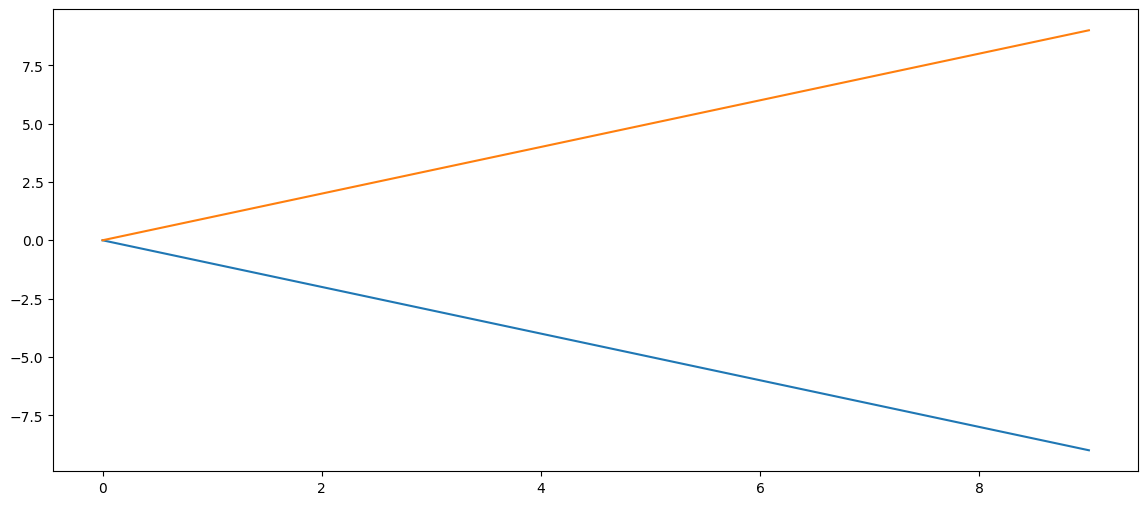

In [81]:
# Demonstracja na przykładzie losowego agenta vs agenta używającego MCTS

class RandomAgent(OpenSpielAgent):
  def __init__(self, game):
    super().__init__(game)

  def step(self, state):
    return np.random.choice(state.legal_actions())


game = pyspiel.load_game("connect_four")
random_agent = RandomAgent(game)
enemy = mcts.MCTSBot(game, sqrt(2), 100, mcts.RandomRolloutEvaluator())
rewards = play_game(game, (random_agent, enemy), 10, plot=True, plot_interval=2)

## Zad 2 - Monte Carlo Tree Search (20pkt)

W komórkach poniżej zaimplementuj Agenta używającego Monte Carlo Tree Search dla środowiska `Connect Four`. Użyj losowej polityki rolloutu oraz polityki drzewa opartej o UCB.

Odpowiedz na pytania (bonusowe):
- Ile stanów posiada środowisko `Connect Four` (ile wierzchołków ma drzewo stanów, możesz policzyć za pomocą komutera).
- Czy widzisz jakiś sprytny sposób na mniejszenie przestrzeni stanów dla gry `Connect Four`? (nie implemnetuj jej).

Uwagi:
- Zadbaj o to by wybór ruch przez Twojego agenta nie trwał dłużej niż 1-2 sekundy.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Agent powinen wygrywać albo remisować większość gier, które rozpoczyna przeciwko innemu silnemu graczowi (np. gotowemu botowi MCTS).

#### Uwaga: nie zmieniaj nazwy klasy `MCTSAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi:
- $3^{42}$ naiwnie 42 pola po 3 stany ( puste, czerowne, żółte ), a obliczone 4531985219092 stanów ( source: https://math.stackexchange.com/questions/301106/how-many-different-game-situations-has-connect-four )
- Symetria planszy? zmniejszenie liczby stanów przez zliczanie stanów symetrycznych i ich redukcję do jednego stanu. nie jestem pewny czy to zadziała, ale wydaje mi się, że tak.

In [97]:
from dataclasses import dataclass
from numpy.random import random
from time import time
import math

class State(object):
  def __init__(
      self,
      state,
      is_player,
      parent=None,
      action=None
  ):
    self.state = state
    self.is_player = is_player

    self.parent = parent
    self.action = action
    self.visit_count = 0

    self.value = 0
    self.children = []
    self.explorable = sorted(deepcopy(state.legal_actions()), key=lambda _: random())

  @property
  def best(self):
    return max(self.children, key=self.evaluate_against)

  def visit(self, action):
    state = self.state.clone()
    state.apply_action(action)

    return State(state, 1 - self.is_player, self, action)

  def evaluate_against(self, other):
    return - other.value / other.visit_count + sqrt(2 * math.log(self.visit_count) / other.visit_count)


In [98]:
class MCTSAgent(OpenSpielAgent):
  def __init__(
      self,
      game,
      time_limit: float = 1,
      iterations_limit: int = 10_000
  ):
    super().__init__(game)
    self.time_limit = time_limit
    self.iterations_limit = iterations_limit

  def step(self, state):
    start = time()

    root = State(state=state, is_player=state.current_player())

    iterations = self.iterations_limit
    while iterations := iterations - 1:
      if time() - start > self.time_limit: break

      node = root
      while node.children and not node.explorable:
        node = node.best

      if node.explorable:
        next_state = node.visit(node.explorable.pop())
        node.children.append(next_state)
        node = next_state

      sample = node.state.clone()
      while not sample.is_terminal():
        sample.apply_action(np.random.choice(sample.legal_actions()))

      while node:
        node.value += sample.player_reward(node.is_player)
        node.visit_count += 1

        node = node.parent

    return max(root.children, key=lambda n: n.visit_count).action

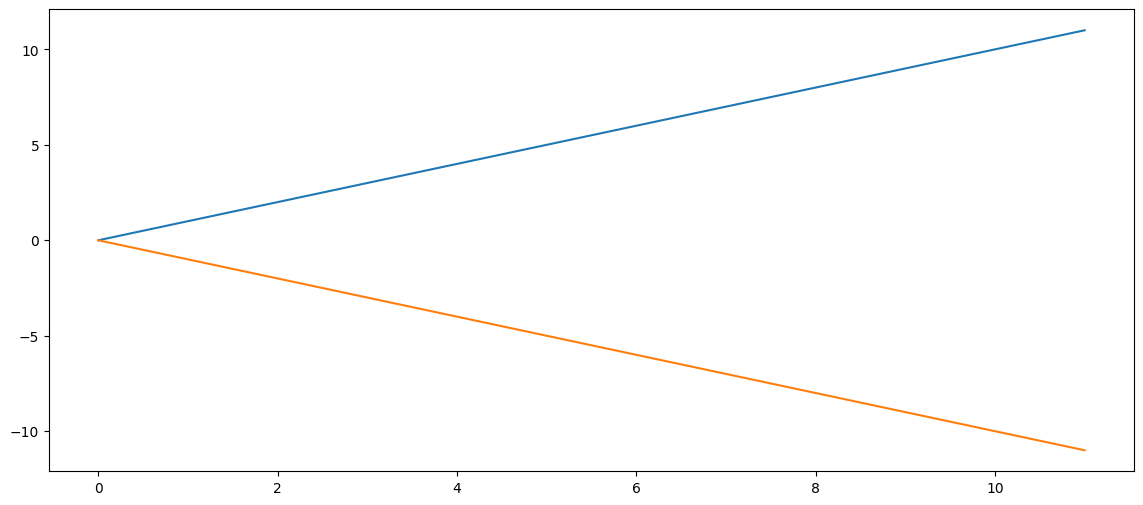

KeyboardInterrupt: 

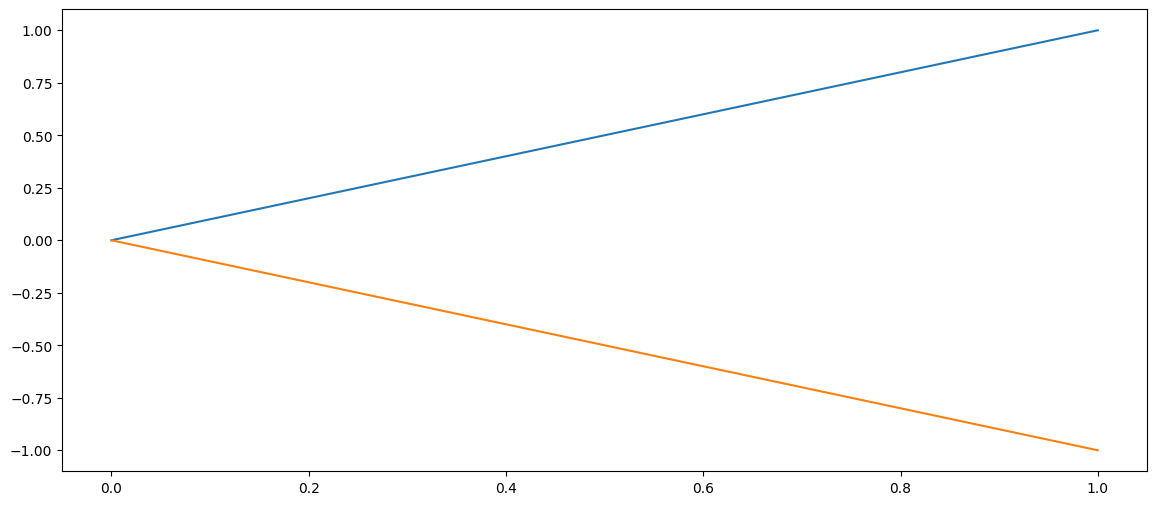

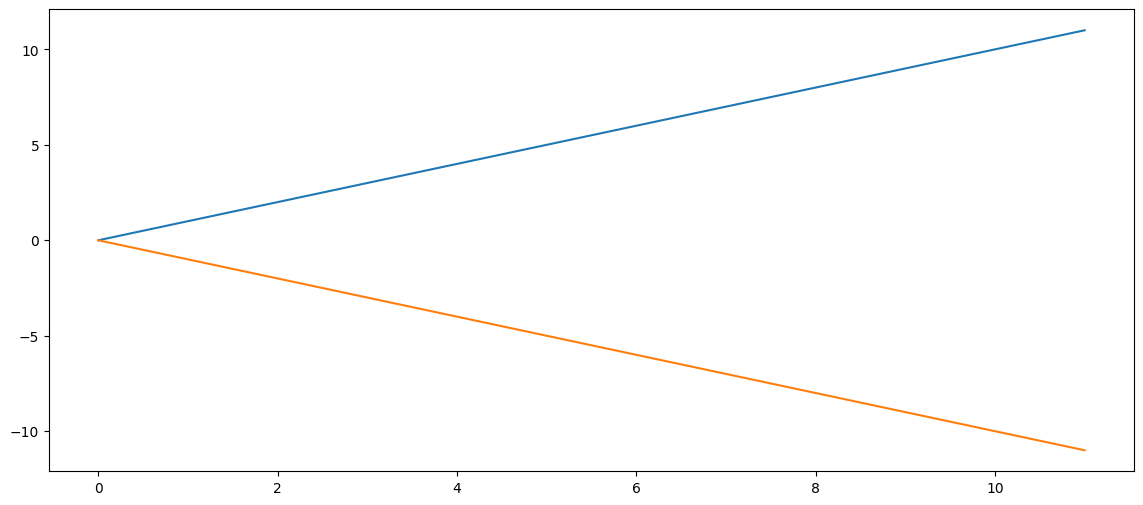

In [87]:
game = pyspiel.load_game("connect_four")
player = MCTSAgent(game)
enemy = mcts.MCTSBot(game, np.sqrt(2), 100, mcts.RandomRolloutEvaluator())
play_game(game, misery := (player, enemy), 100, plot=True, plot_interval=10)